# 20Newsgroup data

## Introduction

In this notebook, we will demonstrate how to use the following functions on the 20Newsgroup data
- fejad

Each document is associated with 1 of 20 newsgroup topics, organized at two
hierarchical levels.

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import relastat as rs

In [2]:
# pip install git+ssh://git@github.com/anniegray52/relastat.git --upgrade

## Data load

Import data and create dataframe.

In [3]:
newsgroups = fetch_20newsgroups() 

df = pd.DataFrame()
df["data"] = newsgroups["data"]
df["target"] = newsgroups["target"]
df["target_names"] = df.target.apply(
    lambda row: newsgroups["target_names"][row])
df[['layer1', 'layer2']] = df['target_names'].str.split('.', n=1, expand=True)

In [4]:
df.head()

,data,target,target_names,layer1,layer2
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos,rec,autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware,comp,sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics,comp,graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space,sci,space


For a random sample of the data, create tf-idf features.

In [5]:
n = 5000
df = df.sample(n=n, replace=False, random_state=22).reset_index(drop=True)

`rs.'matrix_from_text' - creates a Y matrix of tf-idf features. It takes in a dataframe and the column which contains the data. Further functionality includes: removing general stopwords, adding stopwords, removing email addresses, cleaning (lemmatize and remove symbol, lowercase letters) and a threshold for the min/max number of documents a word needs to appear in to be included.

In [6]:
Y, attributes = rs.matrix_from_text(df, 'data', remove_stopwords=True, clean_text=True,
                                    remove_email_addresses=True, update_stopwords=['subject'],
                                    min_df=5, max_df=len(df)-1000)

In [7]:
(n,p) = Y.shape
print("n = {}, p = {}".format(n,p))

n = 5000, p = 12804


Perform dimension selection using Wasserstein distances, see xxx for details

In [9]:
ws = rs.WassersteinDimensionSelect(Y, range(50), split=0.5)
dim = np.argmin(ws)

2024-06-07 14:48:25.760727: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 14:48:25.810307: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:48:26.800741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow warnings are seemingly a bug in ot, ignore them
Number of dimensions: 0, Wasserstein distance 1.00000
Number of dimensions: 1, Wasserstein distance 0.98921
Number of dimensions: 2, Wasserstein distance 0.98636
Number of dimensions: 3, Wasserstein distance 0.98496
Number of dimensions: 4, Wasserstein distance 0.98323
Number of dimensions: 5, Wasserstein distance 0.98203
Number of dimensions: 6, Wasserstein distance 0.98083
Number of dimensions: 7, Wasserstein distance 0.97970
Number of dimensions: 8, Wasserstein distance 0.97880
Number of dimensions: 9, Wasserstein distance 0.97796
Number of dimensions: 10, Wasserstein distance 0.97731
Number of dimensions: 11, Wasserstein distance 0.97639
Number of dimensions: 12, Wasserstein distance 0.97577
Number of dimensions: 13, Wasserstein distance 0.97509
Number of dimensions: 14, Wasserstein distance 0.97479
Number of dimensions: 15, Wasserstein distance 0.97450
Number of dimensions: 16, Wasserstein distance 0.97426
Number of dimens

In [11]:
# dim = 32
print("Selected dimension: {}".format(dim))

Selected dimension: 32


## PCA and tSNE

Now we perform PCA.

In [13]:
zeta = p**-.5 * rs.embed(Y, dim, version='full')

Apply t-SNE

In [14]:
from sklearn.manifold import TSNE

tsne_zeta = TSNE(n_components=2, perplexity=30).fit_transform(zeta)

Make dataframes of PCA embedding and t-SNE embedding for plotting

In [15]:
zeta_df = pd.DataFrame(zeta[:, :2])
zeta_df["target"] = np.array(df['target_names'])
targets = zeta_df["target"].unique()
targets = sorted(targets)
labels = df['target']

tsne_zeta_df = pd.DataFrame(tsne_zeta)
tsne_zeta_df["target"] = np.array(df['target_names'])
targets = tsne_zeta_df["target"].unique()
targets = sorted(targets)

Colours dictionary where topics from the same theme have different shades of the same colour

In [16]:
target_colour = {'alt.atheism': 'goldenrod',
                 'comp.graphics': 'steelblue',
                 'comp.os.ms-windows.misc': 'skyblue',
                 'comp.sys.ibm.pc.hardware': 'lightblue',
                 'comp.sys.mac.hardware': 'powderblue',
                 'comp.windows.x': 'deepskyblue',
                 'misc.forsale': 'maroon',
                 'rec.autos': 'limegreen',
                 'rec.motorcycles': 'green',
                 'rec.sport.baseball': 'yellowgreen',
                 'rec.sport.hockey': 'olivedrab',
                 'sci.crypt': 'pink',
                 'sci.electronics': 'plum',
                 'sci.med': 'orchid',
                 'sci.space': 'palevioletred',
                 'soc.religion.christian': 'darkgoldenrod',
                 'talk.politics.guns': 'coral',
                 'talk.politics.mideast': 'tomato',
                 'talk.politics.misc': 'darksalmon',
                 'talk.religion.misc': 'gold'}

Plot PCA on the LHS and PCA + t-SNE on the RHS

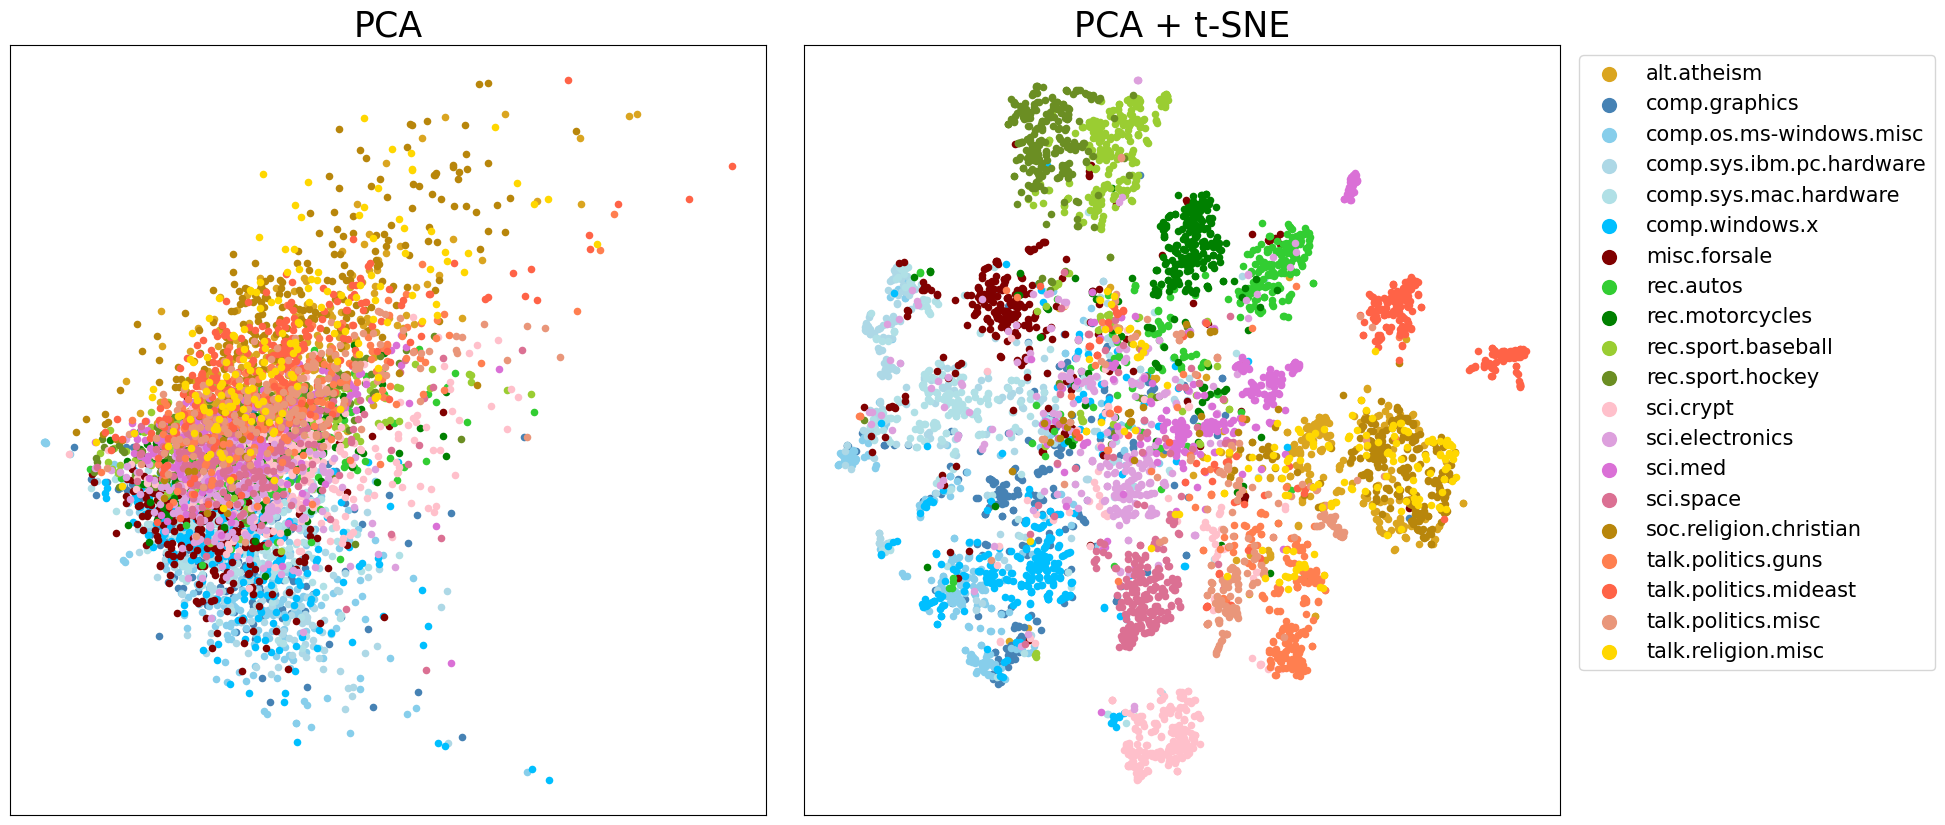

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for t in targets:
    t_df = zeta_df[zeta_df['target'] == t]
    ax[0].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, c=target_colour[t])
ax[0].set_title(f'PCA', fontsize=25)
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)

for t in targets:
    t_df = tsne_zeta_df[tsne_zeta_df['target'] == t]
    ax[1].scatter(t_df[0], t_df[1], marker='o', edgecolor='black',
                  linewidth=0, s=30, label=t, alpha=1, c=target_colour[t])
ax[1].set_title(f'PCA + t-SNE', fontsize=25)
ax[1].legend(loc='upper right', bbox_to_anchor=(
    1.51, 1), prop={'size': 15}, markerscale=2)
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig(f"newsgroup.pdf", bbox_inches='tight')

## Hierarchical clustering

Here, we agglomerative clustering with dot products. More details can be found .. 

First we do this for the centroids of each topic and plot the dendrogram. Then we do HC on the whole dataset and visualise the output tree. 

In [24]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

def ip_metric(X, Y):
    return np.sum(X * Y)


def dp_affinity(X):
    ips = pairwise_distances(X, metric=ip_metric)
    return np.max(ips) - ips

Find the centroids

In [21]:
idxs = [np.where(np.array(df['target']) == t)[0]
        for t in sorted(df['target'].unique())]
t_zeta = np.array([np.mean(zeta[idx, :], axis=0) for idx in idxs])
t_Y = np.array([np.mean(Y[idx, :],axis = 0) for idx in idxs]).reshape(len(sorted(df['target'].unique())),p)

Topic HC clustering

In [25]:
t_dp_clust = AgglomerativeClustering(
    metric=dp_affinity, linkage='average', distance_threshold=0, compute_distances=True, n_clusters=None)
t_dp_clust = t_dp_clust.fit(t_zeta)

Plot dendrogram

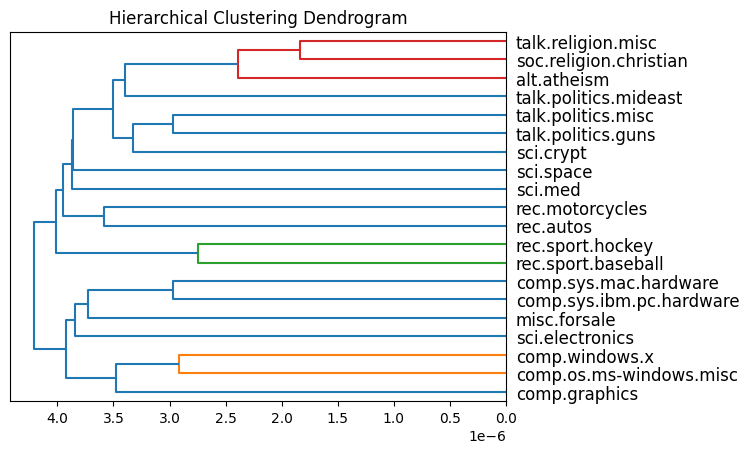

In [26]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
rs.plot_dendrogram(t_dp_clust, orientation='left',
                   labels=sorted(df['target_names'].unique()))
plt.show()

Individual document HC clustering

In [27]:
dp_clust = AgglomerativeClustering(
    metric=dp_affinity, linkage='average', distance_threshold=0, compute_distances=True, n_clusters=None)
dp_clust = dp_clust.fit(zeta)

Plot tree

In [30]:
colours = [target_colour[label] for label in list(df["target_names"])]

rs.plot_HC_clustering(dp_clust, node_colours=colours, internal_node_colour='black', linewidths=.1,
                   edgecolors='black', leaf_node_size=40, fontsize=10, internal_node_size=1, figsize=(10, 10))

## References
